## Experimental Design: Self-Training and Debiasing for Sentiment Analysis

This experiment investigates the effectiveness of self-training with debiasing techniques for improving sentiment analysis performance, particularly in the financial domain. We adapt core concepts from Li et al. (2023) on self-training for Named Entity Recognition (NER) and apply them to sentiment analysis.

**Dataset:**

We use the "Financial Sentiment Analysis" dataset from Kaggle (https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis/data). This dataset contains sentences extracted from financial news articles, labeled with sentiment (positive, neutral, negative).

**Steps:**

1. **Data Splitting:**
   - Divide the dataset into:
       - **`phase1`:** 60% of the data, used for training the base model. This will be further split into:
         - **`phase1_train`:** 60% of `phase1` used for training the model.
         - **`phase1_val`:** 20% of `phase1` used to evaluate the model during training and tune hyperparameters.
         - **`phase1_test`:** 20% of `phase1` used for comparing with pseudo-labeled model performance.
       - **`phase2`:** 40% of the data, used for pseudo-label generation and debiasing. This will be further split into:
         - **`phase2_train`:** 60% of `phase2`.
         - **`phase2_val`:** 20% of `phase2`.
         - **`phase2_test`:** 20% of `phase2`.

2. **Base Model Training:**
   - Train a sentiment analysis model (e.g., FinBERT) on `phase1_train`.
   - Evaluate the base model's performance on `phase1_val`.

3. **Pseudo-Label Generation:**
   - **Duplicate `phase2_train` and create `phase2_pseudo_train`.**
   - Use the trained base model to predict sentiment labels for `phase2_train`. These predicted labels are the "pseudo-labels" and will be stored in `phase2_pseudo_train`, replacing the original labels.

4. **Debiasing:**
   - Apply debiasing techniques to the pseudo-labels (`phase2_pseudo_train`) to reduce noise and bias.
   - Examples of debiasing techniques:
     - Confidence-based filtering: Keep only pseudo-labels with high prediction confidence.
     - Ensemble methods: Use an ensemble of models to generate pseudo-labels and combine their predictions.

5. **Retraining:**
   - Combine `phase2_train` with the debiased pseudo-labeled data (from `phase2_pseudo_train`).
   - Retrain the sentiment analysis model on this combined dataset.
   - Evaluate the performance of the retrained model on the combined validation set (`phase1_val` + `phase2_val`).

6. **Evaluation:**
   - Evaluate the performance (precision, recall, F1-score) of the following models:
     - **Scenario 1: Base Model vs. Debiased-Retrained Model:**
       - Compare the base model's performance (trained on `phase1_train` and evaluated on `phase1_val`) to the debiased-retrained model (trained on `phase1_train` + `phase2_pseudo_train` and evaluated on `phase1_val` + `phase2_val`).
     - **Scenario 2: Comparison of Debiasing Techniques:**
       - Compare the performance of debiased-retrained models (as described in Scenario 1) obtained using different debiasing techniques (e.g., confidence-based filtering vs. ensemble methods).
     - **Scenario 3: Real Labeled Data vs. Pseudo-Labeled Data:**
       - Train a separate model on `phase1_train` + `phase2_train`.
       - Compare the performance of this model (evaluated on `phase1_val` + `phase2_val`) to the debiased-retrained model to assess the effectiveness of using pseudo-labels compared to having more real labeled data.
     - **Additional Comparisons:**
       - Compare the performance of the model trained on `phase1_test` with the model trained on `phase2_test` (with real labels) to further assess the quality of the pseudo-labels.


**Analysis:**

- Compare the performance of different models to assess the effectiveness of self-training and debiasing.
- Analyze the impact of different debiasing techniques.
- Investigate the influence of the amount of labeled data on self-training performance.
- Conduct qualitative analysis of errors to understand the model's behavior.

**Expected Outcome:**

This experiment will provide insights into whether self-training with debiasing can improve sentiment analysis accuracy in the financial domain, especially when labeled data is limited. The findings could have implications for various financial applications, such as market analysis and risk assessment.


In [3]:
!pip install optuna


**Download and store the data**


In [4]:
from google.colab import drive
import kagglehub
import pandas as pd
import re
import json
from sklearn.model_selection import train_test_split

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- Dataset Download ---
path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")
df = pd.read_csv(path + "/data.csv")

# --- Preprocessing the Text ---
def preprocess_text(text):
    cleaned_text = re.sub(r'<[^>]+>', '', str(text))  # Remove HTML tags
    return cleaned_text.strip().lower()  # Lowercase and remove extra spaces

df['processed_text'] = df['Sentence'].apply(preprocess_text)

# --- Print Pre-Conversion Counts ---
print("Unique sentiment values (before conversion):")
print(df['Sentiment'].value_counts())

# --- Text-to-Numeric Conversion ---
sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['Sentiment'] = df['Sentiment'].map(sentiment_map)

# Validation: Check if any unmapped or missing values remain
if df['Sentiment'].isnull().any():
    print("\nError: Some sentiment labels were not successfully converted.")
    print("Unmapped or missing Sentiment values:")
    print(df[df['Sentiment'].isnull()])
else:
    print("\nAll sentiment labels successfully converted to numeric values.")

# Print Post-Conversion Counts
print("\nUnique sentiment values (after conversion):")
print(df['Sentiment'].value_counts())

# --- Splitting the Data ---
# Split labeled and unlabeled data
phase1_data, phase2_data = train_test_split(df, test_size=0.4, random_state=42)

# Split phase1 (labeled) data
phase1_train, phase1_test = train_test_split(phase1_data, test_size=0.2, random_state=42)
phase1_train, phase1_val = train_test_split(phase1_train, test_size=0.25, random_state=42)

# Split phase2 (unlabeled) data
phase2_train, phase2_test = train_test_split(phase2_data, test_size=0.25, random_state=42)
phase2_train, phase2_val = train_test_split(phase2_train, test_size=0.33, random_state=42)

# --- Preserve Labels ---
# Ensure no labels are dropped; validate presence of labels in all splits
def validate_labels(data, split_name):
    if data['Sentiment'].isnull().any():
        print(f"\nError: Missing labels detected in {split_name}.")
        print(data[data['Sentiment'].isnull()])
    else:
        print(f"\nAll records in {split_name} have valid labels.")
        print(data['Sentiment'].value_counts())

validate_labels(phase1_train, "phase1_train")
validate_labels(phase1_val, "phase1_val")
validate_labels(phase1_test, "phase1_test")
validate_labels(phase2_train, "phase2_train")
validate_labels(phase2_val, "phase2_val")
validate_labels(phase2_test, "phase2_test")

# Add metadata columns to distinguish labeled vs. unlabeled
phase1_train['is_labeled'] = True
phase1_val['is_labeled'] = True
phase1_test['is_labeled'] = True

phase2_train['is_labeled'] = True  # Retain original labels in phase2 splits
phase2_val['is_labeled'] = True
phase2_test['is_labeled'] = True

# --- Combine phase1 and phase2 data ---
combined_train = pd.concat(
    [phase1_train[['Sentence', 'processed_text', 'Sentiment', 'is_labeled']],
     phase2_train[['Sentence', 'processed_text', 'Sentiment', 'is_labeled']]],
    axis=0, ignore_index=True
)

combined_val = pd.concat(
    [phase1_val[['Sentence', 'processed_text', 'Sentiment', 'is_labeled']],
     phase2_val[['Sentence', 'processed_text', 'Sentiment', 'is_labeled']]],
    axis=0, ignore_index=True
)

combined_test = pd.concat(
    [phase1_test[['Sentence', 'processed_text', 'Sentiment', 'is_labeled']],
     phase2_test[['Sentence', 'processed_text', 'Sentiment', 'is_labeled']]],
    axis=0, ignore_index=True
)

# Validate combined datasets
validate_labels(combined_train, "combined_train")
validate_labels(combined_val, "combined_val")
validate_labels(combined_test, "combined_test")

# --- Save Combined Data Splits to Google Drive ---
splits_file_path = '/content/drive/My Drive/data_splits.json'

data_splits = {
    "phase1_train": phase1_train.to_dict(orient="records"),
    "phase1_val": phase1_val.to_dict(orient="records"),
    "phase1_test": phase1_test.to_dict(orient="records"),
    "phase2_train": phase2_train.to_dict(orient="records"),
    "phase2_val": phase2_val.to_dict(orient="records"),
    "phase2_test": phase2_test.to_dict(orient="records"),
    "combined_train": combined_train.to_dict(orient="records"),
    "combined_val": combined_val.to_dict(orient="records"),
    "combined_test": combined_test.to_dict(orient="records")
}

with open(splits_file_path, 'w') as f:
    json.dump(data_splits, f)

print(f"\nData splits including combined datasets saved to Google Drive: {splits_file_path}")


Mounted at /content/drive


100%|██████████| 276k/276k [00:00<00:00, 461kB/s]

Extracting files...


Unique sentiment values (before conversion):
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

All sentiment labels successfully converted to numeric values.

Unique sentiment values (after conversion):
Sentiment
1    3130
2    1852
0     860
Name: count, dtype: int64

All records in phase1_train have valid labels.
Sentiment
1    1134
2     638
0     331
Name: count, dtype: int64

All records in phase1_val have valid labels.
Sentiment
1    381
2    238
0     82
Name: count, dtype: int64

All records in phase1_test have valid labels.
Sentiment
1    368
2    226
0    107
Name: count, dtype: int64

All records in phase2_train have valid labels.
Sentiment
1    625
2    377
0    171
Name: count, dtype: int64

All records in phase2_val have valid labels.
Sentiment
1    305
2    191
0     83
Name: count, dtype: int64

All records in phase2_test have valid labels.
Sentiment
1    317
2    182
0     86
Name: count, dtype: int64

All records in combined_train

**Optimize hyperparameters on base model and store**


In [5]:
from google.colab import drive
import json
import pandas as pd
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, EarlyStoppingCallback
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torch
import optuna
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from torch import nn

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- Load Data Splits from Google Drive ---
splits_file_path = '/content/drive/My Drive/data_splits.json'
with open(splits_file_path, 'r') as f:
    data_splits = json.load(f)

# Convert JSON to DataFrames
phase1_train = pd.DataFrame(data_splits["phase1_train"])
phase1_val = pd.DataFrame(data_splits["phase1_val"])
phase1_test = pd.DataFrame(data_splits["phase1_test"])

# --- Handle Class Imbalance ---
X = phase1_train["processed_text"].tolist()
y = phase1_train["Sentiment"].tolist()

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(X).reshape(-1, 1), y)
X_resampled = [text[0] for text in X_resampled]

# --- Tokenize Text ---
def preprocess_function(sentences, tokenizer):
    return tokenizer(sentences, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Prepare Data
def prepare_datasets(tokenizer):
    train_encodings = preprocess_function(X_resampled, tokenizer)
    val_encodings = preprocess_function(phase1_val["processed_text"].tolist(), tokenizer)
    train_dataset = [
        {key: val[idx].clone().detach() for key, val in train_encodings.items()}
        for idx in range(len(X_resampled))
    ]
    val_dataset = [
        {key: val[idx].clone().detach() for key, val in val_encodings.items()}
        for idx in range(len(phase1_val))
    ]
    for idx, label in enumerate(y_resampled):
        train_dataset[idx]['labels'] = torch.tensor(label, dtype=torch.long)
    for idx, label in enumerate(phase1_val["Sentiment"].tolist()):
        val_dataset[idx]['labels'] = torch.tensor(label, dtype=torch.long)
    return train_dataset, val_dataset

# --- Models to Optimize ---
bert_variants = [
    {"name": "ProsusAI/finbert", "save_prefix": "finbert"},
    {"name": "bert-base-uncased", "save_prefix": "bert_base_uncased"},
    {"name": "distilbert-base-uncased", "save_prefix": "distilbert_base_uncased"},
]

# --- Hyperparameter Optimization ---
def optimize_model(model_name, save_prefix):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_dataset, val_dataset = prepare_datasets(tokenizer)

    def objective(trial):
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
        training_args = TrainingArguments(
            output_dir=f"./results_trial_{save_prefix}",  # Ensure results are saved in the correct directory
            num_train_epochs=5,  # Fixed number of epochs
            per_device_train_batch_size=trial.suggest_categorical("batch_size", [8, 16, 32]),
            learning_rate=trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
            weight_decay=trial.suggest_float("weight_decay", 0.001, 0.3),
            warmup_steps=trial.suggest_int("warmup_steps", 100, 500),
            lr_scheduler_type=trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine_with_restarts"]),
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",  # Track F1 score to select the best model
            fp16=True,
            report_to="none",
        )

        # Add dropout to the classification head
        model.classifier = nn.Sequential(
            nn.Dropout(trial.suggest_float("dropout_rate", 0.1, 0.5)),
            nn.Linear(model.config.hidden_size, model.config.num_labels),
        )

        # Define metrics function with accuracy
        def compute_metrics(pred):
            labels = pred.label_ids
            preds = pred.predictions.argmax(-1)
            f1 = f1_score(labels, preds, average="weighted")
            accuracy = accuracy_score(labels, preds)
            precision = precision_score(labels, preds, average="weighted")
            recall = recall_score(labels, preds, average="weighted")
            return {
                "eval_f1": f1,
                "eval_accuracy": accuracy,
                "eval_precision": precision,
                "eval_recall": recall,
            }

        # Early stopping callback
        early_stopping = EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.01,  # Fixed threshold for early stopping
        )

        # Trainer initialization
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping],
        )

        # Train and evaluate
        trainer.train()
        eval_results = trainer.evaluate(eval_dataset=val_dataset)

        # Save the best model for this trial
        trial_model_path = f"/content/drive/My Drive/models/base_model_trial_{trial.number}_{save_prefix}"
        model.save_pretrained(trial_model_path)
        tokenizer.save_pretrained(trial_model_path)
        print(f"Model for trial {trial.number} ({save_prefix}) saved to {trial_model_path}")

        return eval_results["eval_f1"]

    # Optimize and save the best model and hyperparameters
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5)  # Reduced the number of trials to speed up optimization

    best_params = study.best_params
    best_trial = study.best_trial

    # Save the best model (the model from the best trial)
    best_model = AutoModelForSequenceClassification.from_pretrained(f"/content/drive/My Drive/models/base_model_trial_{best_trial.number}_{save_prefix}")
    best_model_path = f"/content/drive/My Drive/models/best_{save_prefix}_model"
    best_model.save_pretrained(best_model_path)
    tokenizer.save_pretrained(best_model_path)

    # Save metadata for the best model
    metadata = {
        "params": best_params,
        "metrics": best_trial.value,
    }
    metadata_path = f"/content/drive/My Drive/models/best_{save_prefix}_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f)

    print(f"Best {save_prefix} model saved to: {best_model_path}")
    print(f"Metadata saved to: {metadata_path}")

# Optimize each model
for variant in bert_variants:
    optimize_model(variant["name"], variant["save_prefix"])


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[I 2024-12-08 17:39:42,382] A new study created in memory with name: no-name-48a244c2-ccf5-44ff-aaec-4f6d9bb831a3


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.013262,0.297865,0.409415,0.372475,0.409415
2,No log,0.798854,0.705417,0.701854,0.802408,0.701854
3,No log,0.638840,0.792043,0.780314,0.846421,0.780314
4,No log,0.565642,0.806487,0.796006,0.858321,0.796006
5,0.746100,0.544148,0.813724,0.803138,0.862129,0.803138


[I 2024-12-08 17:47:03,326] Trial 0 finished with value: 0.8137243900300185 and parameters: {'batch_size': 32, 'learning_rate': 3.0754365651594245e-06, 'weight_decay': 0.10928512513479632, 'warmup_steps': 209, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.4211051537885858}. Best is trial 0 with value: 0.8137243900300185.


Model for trial 0 (finbert) saved to /content/drive/My Drive/models/base_model_trial_0_finbert


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.359291,0.129521,0.124108,0.147874,0.124108
2,No log,1.224236,0.228340,0.225392,0.250288,0.225392
3,No log,1.058997,0.522501,0.527817,0.541535,0.527817
4,No log,0.925173,0.730146,0.714693,0.785603,0.714693
5,1.128500,0.836293,0.771516,0.754636,0.828500,0.754636


[I 2024-12-08 17:54:24,598] Trial 1 finished with value: 0.7715157179624206 and parameters: {'batch_size': 32, 'learning_rate': 1.6510356964969649e-06, 'weight_decay': 0.11272807409618718, 'warmup_steps': 473, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.32010298887874045}. Best is trial 0 with value: 0.8137243900300185.


Model for trial 1 (finbert) saved to /content/drive/My Drive/models/base_model_trial_1_finbert


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.090095,0.463896,0.467903,0.475373,0.467903
2,No log,0.789968,0.793643,0.780314,0.841400,0.780314
3,1.034800,0.655303,0.815283,0.804565,0.862241,0.804565
4,1.034800,0.609341,0.812578,0.801712,0.866745,0.801712
5,0.549300,0.595256,0.816929,0.807418,0.867805,0.807418


[I 2024-12-08 18:02:18,130] Trial 2 finished with value: 0.8169294059678898 and parameters: {'batch_size': 16, 'learning_rate': 2.385499684867198e-06, 'weight_decay': 0.10119214715384002, 'warmup_steps': 259, 'lr_scheduler_type': 'cosine_with_restarts', 'dropout_rate': 0.46286452739998596}. Best is trial 2 with value: 0.8169294059678898.


Model for trial 2 (finbert) saved to /content/drive/My Drive/models/base_model_trial_2_finbert


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,0.960811,0.710834,0.696148,0.767286,0.696148
2,No log,0.755577,0.800164,0.787447,0.847765,0.787447
3,0.936400,0.652068,0.818792,0.807418,0.864697,0.807418
4,0.936400,0.606818,0.818934,0.807418,0.870454,0.807418
5,0.534100,0.584534,0.821442,0.811698,0.866867,0.811698


[I 2024-12-08 18:10:16,794] Trial 3 finished with value: 0.8214422864649462 and parameters: {'batch_size': 16, 'learning_rate': 2.2312211640110957e-06, 'weight_decay': 0.20778466788252614, 'warmup_steps': 117, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.2991428580039195}. Best is trial 3 with value: 0.8214422864649462.


Model for trial 3 (finbert) saved to /content/drive/My Drive/models/base_model_trial_3_finbert


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.056534,0.528947,0.532097,0.546090,0.532097
2,No log,0.772350,0.795296,0.783167,0.841862,0.783167
3,0.999100,0.642631,0.817165,0.807418,0.860358,0.807418
4,0.999100,0.588914,0.816403,0.805991,0.866832,0.805991
5,0.522300,0.564226,0.822375,0.813124,0.864983,0.813124


[I 2024-12-08 18:18:23,722] Trial 4 finished with value: 0.8223753449384803 and parameters: {'batch_size': 16, 'learning_rate': 2.4452204776285153e-06, 'weight_decay': 0.276041806515353, 'warmup_steps': 246, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.35943618732244886}. Best is trial 4 with value: 0.8223753449384803.
Some weights of the model checkpoint at /content/drive/My Drive/models/base_model_trial_4_finbert were not used when initializing BertForSequenceClassification: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

Model for trial 4 (finbert) saved to /content/drive/My Drive/models/base_model_trial_4_finbert
Best finbert model saved to: /content/drive/My Drive/models/best_finbert_model
Metadata saved to: /content/drive/My Drive/models/best_finbert_metadata.json


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[I 2024-12-08 18:18:40,710] A new study created in memory with name: no-name-b283bef0-d0fc-45be-9551-b98726b53185


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.102689,0.329125,0.340942,0.398118,0.340942
2,No log,1.045524,0.440194,0.486448,0.574092,0.486448
3,1.110600,0.994713,0.558550,0.546362,0.606868,0.546362
4,1.110600,0.980061,0.587193,0.564907,0.649383,0.564907
5,0.983400,0.961553,0.584842,0.566334,0.645307,0.566334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-12-08 18:26:38,729] Trial 0 finished with value: 0.5871926043983098 and parameters: {'batch_size': 16, 'learning_rate': 1.3066007246024897e-06, 'weight_decay': 0.25657489568996206, 'warmup_steps': 452, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.24858524525271572}. Best is trial 0 with value: 0.5871926043983098.


Model for trial 0 (bert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_0_bert_base_uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.042317,0.527298,0.522111,0.575545,0.522111
2,1.102500,0.952745,0.587225,0.580599,0.631560,0.580599
3,0.988500,0.896571,0.612412,0.613409,0.675233,0.613409
4,0.886000,0.869013,0.639285,0.631954,0.698168,0.631954
5,0.818600,0.854274,0.653275,0.643367,0.706580,0.643367


[I 2024-12-08 18:35:34,249] Trial 1 finished with value: 0.6532747910758787 and parameters: {'batch_size': 8, 'learning_rate': 1.1409274327540206e-06, 'weight_decay': 0.17402664842331636, 'warmup_steps': 310, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.36702186486860755}. Best is trial 1 with value: 0.6532747910758787.


Model for trial 1 (bert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_1_bert_base_uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,0.646935,0.755918,0.746077,0.795360,0.746077
2,0.783600,0.656471,0.797352,0.787447,0.828967,0.787447
3,0.338800,0.873252,0.796299,0.788873,0.819595,0.788873
4,0.218000,1.006396,0.793037,0.784593,0.811315,0.784593


[I 2024-12-08 18:42:45,151] Trial 2 finished with value: 0.7973518753344238 and parameters: {'batch_size': 8, 'learning_rate': 1.3585510819298788e-05, 'weight_decay': 0.00662177022515145, 'warmup_steps': 171, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.489634795967003}. Best is trial 2 with value: 0.7973518753344238.


Model for trial 2 (bert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_2_bert_base_uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,0.535721,0.787737,0.778887,0.806477,0.778887
2,0.768900,0.650445,0.787120,0.780314,0.810577,0.780314
3,0.319000,0.934141,0.788724,0.781740,0.808842,0.781740


[I 2024-12-08 18:48:14,019] Trial 3 finished with value: 0.7887241772130872 and parameters: {'batch_size': 8, 'learning_rate': 1.941268656391428e-05, 'weight_decay': 0.09183449411113871, 'warmup_steps': 267, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.14165780953494267}. Best is trial 2 with value: 0.7973518753344238.


Model for trial 3 (bert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_3_bert_base_uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,0.733005,0.696987,0.684736,0.743444,0.684736
2,No log,0.553512,0.800650,0.788873,0.837676,0.788873
3,0.692700,0.748367,0.786255,0.777461,0.825047,0.777461
4,0.692700,0.854192,0.784404,0.778887,0.792921,0.778887


[I 2024-12-08 18:54:37,446] Trial 4 finished with value: 0.8006497594448496 and parameters: {'batch_size': 16, 'learning_rate': 4.3627820671758856e-05, 'weight_decay': 0.2025477067224712, 'warmup_steps': 454, 'lr_scheduler_type': 'cosine_with_restarts', 'dropout_rate': 0.4098268902650174}. Best is trial 4 with value: 0.8006497594448496.


Model for trial 4 (bert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_4_bert_base_uncased


Some weights of the model checkpoint at /content/drive/My Drive/models/base_model_trial_4_bert_base_uncased were not used when initializing BertForSequenceClassification: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/models/base_model_trial_4_bert_base_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task 

Best bert_base_uncased model saved to: /content/drive/My Drive/models/best_bert_base_uncased_model
Metadata saved to: /content/drive/My Drive/models/best_bert_base_uncased_metadata.json


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[I 2024-12-08 18:54:50,942] A new study created in memory with name: no-name-e418ab0e-67db-40ec-a226-32cb3c70b287


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.096110,0.356923,0.373752,0.599087,0.373752
2,No log,1.007181,0.521405,0.540656,0.644339,0.540656
3,No log,0.905504,0.587742,0.590585,0.666445,0.590585
4,No log,0.859277,0.655395,0.646220,0.719713,0.646220
5,0.944000,0.847050,0.661805,0.653352,0.721476,0.653352


[I 2024-12-08 18:59:02,716] Trial 0 finished with value: 0.6618053548477084 and parameters: {'batch_size': 32, 'learning_rate': 2.9516175039358066e-06, 'weight_decay': 0.24158151821649826, 'warmup_steps': 125, 'lr_scheduler_type': 'cosine_with_restarts', 'dropout_rate': 0.1942031153899989}. Best is trial 0 with value: 0.6618053548477084.


Model for trial 0 (distilbert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_0_distilbert_base_uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.075222,0.501956,0.479315,0.573533,0.479315
2,No log,0.911598,0.614035,0.619116,0.706605,0.619116
3,1.007800,0.786079,0.705612,0.693295,0.743301,0.693295
4,1.007800,0.738326,0.713574,0.700428,0.753460,0.700428
5,0.672400,0.720658,0.720584,0.707561,0.762650,0.707561


[I 2024-12-08 19:03:29,394] Trial 1 finished with value: 0.7205836224457302 and parameters: {'batch_size': 16, 'learning_rate': 2.781685908045043e-06, 'weight_decay': 0.18964340245627018, 'warmup_steps': 240, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.38124520898569425}. Best is trial 1 with value: 0.7205836224457302.


Model for trial 1 (distilbert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_1_distilbert_base_uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.072970,0.456600,0.547789,0.479656,0.547789
2,No log,1.072800,0.503833,0.510699,0.557023,0.510699
3,No log,1.053320,0.493822,0.507846,0.580615,0.507846
4,No log,1.032614,0.508432,0.523538,0.592013,0.523538


[I 2024-12-08 19:06:56,553] Trial 2 finished with value: 0.5084321440326178 and parameters: {'batch_size': 32, 'learning_rate': 1.4773369543101907e-06, 'weight_decay': 0.1879589862320077, 'warmup_steps': 158, 'lr_scheduler_type': 'cosine_with_restarts', 'dropout_rate': 0.38347938953582605}. Best is trial 1 with value: 0.7205836224457302.


Model for trial 2 (distilbert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_2_distilbert_base_uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.060062,0.555988,0.554922,0.557168,0.554922
2,No log,0.847038,0.604666,0.617689,0.679024,0.617689
3,No log,0.610644,0.766212,0.754636,0.800218,0.754636
4,No log,0.538912,0.783085,0.770328,0.815334,0.770328
5,0.705600,0.541251,0.794897,0.784593,0.817509,0.784593


[I 2024-12-08 19:11:16,576] Trial 3 finished with value: 0.7948974684086327 and parameters: {'batch_size': 32, 'learning_rate': 1.368758102675347e-05, 'weight_decay': 0.2814727599631226, 'warmup_steps': 407, 'lr_scheduler_type': 'linear', 'dropout_rate': 0.23588843373387555}. Best is trial 3 with value: 0.7948974684086327.


Model for trial 3 (distilbert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_3_distilbert_base_uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,1.052507,0.526299,0.504993,0.616310,0.504993
2,1.063600,0.842867,0.690431,0.680456,0.741877,0.680456
3,0.841300,0.752422,0.712559,0.699001,0.752105,0.699001
4,0.658700,0.728973,0.719392,0.706134,0.762468,0.706134
5,0.607500,0.720766,0.722100,0.708987,0.764521,0.708987


[I 2024-12-08 19:16:19,119] Trial 4 finished with value: 0.7221004841948239 and parameters: {'batch_size': 8, 'learning_rate': 1.7180119898761843e-06, 'weight_decay': 0.16074939009263695, 'warmup_steps': 202, 'lr_scheduler_type': 'cosine_with_restarts', 'dropout_rate': 0.1829721577254933}. Best is trial 3 with value: 0.7948974684086327.
Some weights of the model checkpoint at /content/drive/My Drive/models/base_model_trial_3_distilbert_base_uncased were not used when initializing DistilBertForSequenceClassification: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

Model for trial 4 (distilbert_base_uncased) saved to /content/drive/My Drive/models/base_model_trial_4_distilbert_base_uncased
Best distilbert_base_uncased model saved to: /content/drive/My Drive/models/best_distilbert_base_uncased_model
Metadata saved to: /content/drive/My Drive/models/best_distilbert_base_uncased_metadata.json


**Generate pseudo label variations**

In [6]:
from google.colab import drive
import json
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- Load Data Splits from Google Drive ---
splits_file_path = '/content/drive/My Drive/data_splits.json'
with open(splits_file_path, 'r') as f:
    data_splits = json.load(f)

# Load training data for predictions
phase2_train = pd.DataFrame(data_splits["phase2_train"])

# --- Pre-Trained Fine-Tuned Models ---
model_paths = [
    "/content/drive/My Drive/models/best_finbert_model",  # Best FinBERT model
    "/content/drive/My Drive/models/best_bert_base_uncased_model",  # Best BERT-base model
    "/content/drive/My Drive/models/best_distilbert_base_uncased_model",  # Best DistilBERT model
]

models = []
tokenizers = []

# Load each model and tokenizer
for model_path in model_paths:
    print(f"Loading model from: {model_path}")
    tokenizers.append(AutoTokenizer.from_pretrained(model_path))
    models.append(AutoModelForSequenceClassification.from_pretrained(model_path))

# --- Tokenization Function ---
def preprocess_function(tokenizer, sentences):
    return tokenizer(
        sentences,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

# --- Generate Predictions Using Fine-Tuned Models ---
def generate_predictions(models, tokenizers, data):
    all_predictions = {}

    for model, tokenizer in zip(models, tokenizers):
        model_name = os.path.basename(model.config._name_or_path)  # Get the model name
        print(f"Generating predictions with model: {model_name}")

        encodings = preprocess_function(tokenizer, data["processed_text"].tolist())
        inputs = encodings["input_ids"]
        attention_mask = encodings["attention_mask"]

        with torch.no_grad():
            logits = model(input_ids=inputs, attention_mask=attention_mask).logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            pseudo_labels = probs.argmax(dim=-1).tolist()  # Get predicted classes
            confidences = probs.max(dim=-1).values.tolist()  # Get confidence scores

        all_predictions[model_name] = {
            "Sentences": data["processed_text"].tolist(),
            "Predictions": pseudo_labels,
            "Confidences": confidences,
        }

    return all_predictions

# Generate predictions for phase2_train using fine-tuned models
fine_tuned_predictions = generate_predictions(models, tokenizers, phase2_train)

# --- Save Predictions ---
def save_predictions(predictions, filename):
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv(f"/content/drive/My Drive/{filename}", index=False)
    print(f"Predictions saved to {filename}")

# Save fine-tuned model predictions
for model_name, preds in fine_tuned_predictions.items():
    filename = f"predictions_{model_name}.csv"
    save_predictions({
        "Sentence": preds["Sentences"],
        "Prediction": preds["Predictions"],
        "Confidence": preds["Confidences"]
    }, filename)

print("All predictions saved successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from: /content/drive/My Drive/models/best_finbert_model
Loading model from: /content/drive/My Drive/models/best_bert_base_uncased_model
Loading model from: /content/drive/My Drive/models/best_distilbert_base_uncased_model
Generating predictions with model: best_finbert_model
Generating predictions with model: best_bert_base_uncased_model
Generating predictions with model: best_distilbert_base_uncased_model
Predictions saved to predictions_best_finbert_model.csv
Predictions saved to predictions_best_bert_base_uncased_model.csv
Predictions saved to predictions_best_distilbert_base_uncased_model.csv
All predictions saved successfully.


**Generate training scenarios**

In [7]:
import pandas as pd
import json

from google.colab import drive
drive.mount('/content/drive')

# --- Mount Google Drive ---
BASE_PATH = '/content/drive/My Drive'
DATA_SPLITS_PATH = f'{BASE_PATH}/data_splits.json'

# --- Load Data Splits ---
with open(DATA_SPLITS_PATH, 'r') as f:
    data_splits = json.load(f)

# Load predictions
prediction_files = {
    "finbert_default": f"{BASE_PATH}/predictions_finbert_default.csv",
    "finbert_tuned": f"{BASE_PATH}/predictions_best_finbert_model.csv",
    "bert_base": f"{BASE_PATH}/predictions_best_bert_base_uncased_model.csv",
    "distilbert_base": f"{BASE_PATH}/predictions_best_distilbert_base_uncased_model.csv",
}

# Load prediction data
predictions_data = {name: pd.read_csv(file) for name, file in prediction_files.items()}

# --- Pseudo-Labeling Logic ---
def generate_self_labeled_data(data, method, predictions, confidences=None, **kwargs):
    if method == "unfiltered":
        data["Filtered_Prediction"] = predictions
    elif method == "confidence":
        threshold = kwargs.get("threshold", 0.5)
        # Filter by confidence threshold
        high_conf_indices = [i for i, conf in enumerate(confidences) if conf >= threshold]
        print(f"Confidence filtering: {len(high_conf_indices)} high-confidence predictions retained.")
        data = data.iloc[high_conf_indices].copy()
        data["Filtered_Prediction"] = [predictions[i] for i in high_conf_indices]
    elif method == "ensemble":
        agreement_threshold = kwargs.get("agreement_threshold", 0.6)
        # Filter by ensemble agreement
        instance_agreement = list(zip(*predictions))
        filtered_indices = []

        for i, preds in enumerate(instance_agreement):
            counts = pd.Series(preds).value_counts(normalize=True)
            max_agreement = counts.max()
            consensus_label = counts.idxmax()

            if max_agreement >= agreement_threshold:
                filtered_indices.append((i, consensus_label))

        print(f"Ensemble filtering: {len(filtered_indices)} entries retained after agreement threshold.")
        data = data.iloc[[idx for idx, _ in filtered_indices]].copy()
        data["Filtered_Prediction"] = [label for _, label in filtered_indices]

    return data

# --- Generate Datasets ---
finbert_tuned_data = predictions_data["finbert_tuned"]
finbert_predictions = finbert_tuned_data["Prediction"].tolist()

# Ensure confidence scores are available
if "Confidence" not in finbert_tuned_data.columns:
    raise ValueError("Confidence column missing from finbert_tuned predictions!")

finbert_confidences = finbert_tuned_data["Confidence"].tolist()

# Unfiltered using finbert_tuned
pseudo_labeled_unfiltered = generate_self_labeled_data(finbert_tuned_data.copy(), "unfiltered", finbert_predictions)

# Confidence-based using finbert_tuned
pseudo_labeled_confidence = generate_self_labeled_data(
    finbert_tuned_data.copy(), "confidence", finbert_predictions, finbert_confidences, threshold=0.5
)

# Ensemble using all models
ensemble_predictions = [data["Prediction"].tolist() for data in predictions_data.values()]
pseudo_labeled_ensemble = generate_self_labeled_data(
    finbert_tuned_data.copy(), "ensemble", ensemble_predictions, agreement_threshold=0.6
)

# --- Save Pseudo-Labeled Datasets ---
pseudo_labeled_datasets = {
    "unfiltered_train": pseudo_labeled_unfiltered,
    "confidence_train": pseudo_labeled_confidence,
    "ensemble_train": pseudo_labeled_ensemble,
}

def save_predictions(dataset, filename):
    # Save only Sentence and Filtered_Prediction columns
    dataset[["Sentence", "Filtered_Prediction"]].to_csv(f"{BASE_PATH}/{filename}", index=False)
    print(f"Saved dataset to {BASE_PATH}/{filename}")

# Save each pseudo-labeled dataset
for name, dataset in pseudo_labeled_datasets.items():
    save_predictions(dataset, f"pseudo_labeled_{name}.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Confidence filtering: 25 high-confidence predictions retained.
Ensemble filtering: 719 entries retained after agreement threshold.
Saved dataset to /content/drive/My Drive/pseudo_labeled_unfiltered_train.csv
Saved dataset to /content/drive/My Drive/pseudo_labeled_confidence_train.csv
Saved dataset to /content/drive/My Drive/pseudo_labeled_ensemble_train.csv


**Generate training sets with original labeled data**

In [8]:
from sklearn.utils import resample
import pandas as pd
import json
import numpy as np

# Define sentiment map for text-to-numeric conversion
sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}

# Load data splits from file
splits_file_path = '/content/drive/My Drive/data_splits.json'
with open(splits_file_path, 'r') as f:
    data_splits = json.load(f)

# Print keys in the data splits for verification
print("Keys in data_splits:", data_splits.keys())

# Access the combined training dataset directly
combined_train = pd.DataFrame(data_splits["combined_train"])[["Sentence", "Sentiment"]]
print("\nSample rows from combined_train (before renaming):")
print(combined_train.head())

# Convert Sentiment column to numeric using sentiment map
print("\nUnique values in combined_train['Sentiment'] before remapping:")
print(combined_train["Sentiment"].unique())
combined_train["Sentiment"] = combined_train["Sentiment"].map(sentiment_map).fillna(combined_train["Sentiment"])
print("\nUnique values in combined_train['Sentiment'] after remapping:")
print(combined_train["Sentiment"].unique())
print("\nSample rows from combined_train (after numeric conversion):")
print(combined_train.head())

# Rename columns for consistency
combined_train.rename(columns={"Sentence": "Text", "Sentiment": "Label"}, inplace=True)
print("\nSample rows from combined_train (after renaming):")
print(combined_train.head())

# Save the full combined training dataset
full_train_combined_path = "/content/drive/My Drive/full_train_combined.csv"
combined_train.to_csv(full_train_combined_path, index=False)
print(f"Full combined training dataset saved to {full_train_combined_path}")

# File paths for pseudo-labeled datasets
pseudo_labeled_files = {
    "unfiltered_train": "/content/drive/My Drive/pseudo_labeled_unfiltered_train.csv",
    "confidence_train": "/content/drive/My Drive/pseudo_labeled_confidence_train.csv",
    "ensemble_train": "/content/drive/My Drive/pseudo_labeled_ensemble_train.csv"
}

# Function to rebalance datasets
def rebalance_data(data, label_column):
    print(f"\nClass distribution before rebalancing:\n{data[label_column].value_counts()}")

    # Separate classes
    class_dfs = [data[data[label_column] == label] for label in data[label_column].unique()]

    # Determine the target size (e.g., majority class size or a fixed limit)
    target_size = min(len(class_df) for class_df in class_dfs)  # Can adjust to "max" or other strategies

    # Resample each class to the target size
    rebalanced_dfs = [resample(class_df, replace=True, n_samples=target_size, random_state=42)
                      for class_df in class_dfs]

    # Combine rebalanced classes
    rebalanced_data = pd.concat(rebalanced_dfs).sample(frac=1, random_state=42)  # Shuffle

    print(f"Class distribution after rebalancing:\n{rebalanced_data[label_column].value_counts()}")
    return rebalanced_data

# Process each pseudo-labeled dataset
for scenario, file_path in pseudo_labeled_files.items():
    print(f"\nProcessing pseudo-labeled dataset: {scenario}")

    # Load the pseudo-labeled dataset
    pseudo_labeled_data = pd.read_csv(file_path)
    print(f"Sample rows from {scenario} (before renaming):")
    print(pseudo_labeled_data.head())

    # Rename columns for consistency
    pseudo_labeled_data.rename(columns={"Sentence": "Text", "Filtered_Prediction": "Label"}, inplace=True)
    print(f"Sample rows from {scenario} (after renaming):")
    print(pseudo_labeled_data.head())

    # Ensure pseudo-labeled data has numeric labels
    pseudo_labeled_data["Label"] = pseudo_labeled_data["Label"].map(sentiment_map).fillna(pseudo_labeled_data["Label"])
    print(f"Sample rows from {scenario} (after numeric conversion):")
    print(pseudo_labeled_data.head())

    # Rebalance pseudo-labeled data before combining
    pseudo_labeled_data = rebalance_data(pseudo_labeled_data, label_column="Label")

    # Combine (union) labeled data with pseudo-labeled data
    scenario_combined = pd.concat([combined_train, pseudo_labeled_data], axis=0, ignore_index=True)

    # Verify that no rows were lost during concatenation
    expected_row_count = len(combined_train) + len(pseudo_labeled_data)
    actual_row_count = len(scenario_combined)
    if expected_row_count != actual_row_count:
        print(f"Error: Row mismatch detected for {scenario}. Expected {expected_row_count}, but got {actual_row_count}.")
    else:
        print(f"Row counts match for {scenario}: {actual_row_count} rows.")

    print(f"Class distribution in the combined dataset ({scenario}) before final rebalancing:")
    print(scenario_combined["Label"].value_counts())

    # Final rebalancing of the combined dataset
    scenario_combined = rebalance_data(scenario_combined, label_column="Label")

    # Save the final balanced combined dataset using original filenames
    scenario_combined.to_csv(file_path, index=False)
    print(f"Final balanced combined dataset for {scenario} saved to {file_path}")


Keys in data_splits: dict_keys(['phase1_train', 'phase1_val', 'phase1_test', 'phase2_train', 'phase2_val', 'phase2_test', 'combined_train', 'combined_val', 'combined_test'])

Sample rows from combined_train (before renaming):
                                            Sentence  Sentiment
0  Neste Oil s refineries have a combined crude o...          1
1  Finnlines estimated in its annual general meet...          0
2  `` Every partner will be allowed to buy a quan...          1
3  In the first nine months of 2010 , the company...          2
4  The total value of the deliveries is some EUR6...          1

Unique values in combined_train['Sentiment'] before remapping:
[1 0 2]

Unique values in combined_train['Sentiment'] after remapping:
[1. 0. 2.]

Sample rows from combined_train (after numeric conversion):
                                            Sentence  Sentiment
0  Neste Oil s refineries have a combined crude o...        1.0
1  Finnlines estimated in its annual general meet...   

**Train models**

In [9]:
import pandas as pd
import json
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch

# --- Define Custom Dataset ---
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are integers
        return item

# --- Load Best Hyperparameters ---
metadata_path = "/content/drive/My Drive/models/best_finbert_metadata.json"
with open(metadata_path, 'r') as f:
    best_hyperparameters = json.load(f)["params"]

# --- Training Sets ---
training_files = {
    "full_training_combined": "/content/drive/My Drive/full_training_combined.csv",
    "unfiltered_train_combined": "/content/drive/My Drive/unfiltered_train_combined.csv",
    "confidence_train_combined": "/content/drive/My Drive/confidence_train_combined.csv",
    "ensemble_train_combined": "/content/drive/My Drive/ensemble_train_combined.csv"
}

# --- FinBERT Model and Tokenizer ---
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# --- Train and Save Models for Each Training Set ---
for scenario, file_path in training_files.items():
    # Load the dataset
    df = pd.read_csv(file_path)

    # Preprocess and split into train/validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['Text'].tolist(),
        df['Label'].tolist(),
        test_size=0.2,
        random_state=42
    )

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

    # Create PyTorch Datasets
    train_dataset = SentimentDataset(train_encodings, train_labels)
    val_dataset = SentimentDataset(val_encodings, val_labels)

    # Load the FinBERT model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    # Define training arguments using best hyperparameters
    training_args = TrainingArguments(
    output_dir=f"./results_{scenario}",
    num_train_epochs=best_hyperparameters.get("num_train_epochs", 5),
    per_device_train_batch_size=best_hyperparameters["batch_size"],
    learning_rate=best_hyperparameters["learning_rate"],
    weight_decay=best_hyperparameters["weight_decay"],
    warmup_steps=best_hyperparameters["warmup_steps"],
    lr_scheduler_type=best_hyperparameters["lr_scheduler_type"],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir=f"./logs_{scenario}",
    logging_steps=100,
    report_to="none"  # Disable wandb or any other tracking
)

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    print(f"Training FinBERT model for {scenario}...")
    trainer.train()

    # Save the model
    model.save_pretrained(f"/content/drive/My Drive/models/{scenario}")
    tokenizer.save_pretrained(f"/content/drive/My Drive/models/{scenario}")
    print(f"Model for {scenario} saved to /content/drive/My Drive/models/{scenario}")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training FinBERT model for full_training_combined...


Epoch,Training Loss,Validation Loss
1,2.728300,2.568418
2,1.747300,1.096259
3,1.008400,0.799554
4,0.751400,0.709528
5,0.681200,0.693878


Model for full_training_combined saved to /content/drive/My Drive/models/full_training_combined


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training FinBERT model for unfiltered_train_combined...


Epoch,Training Loss,Validation Loss
1,1.650600,0.995850
2,0.717800,0.644591
3,0.557300,0.564662
4,0.486600,0.532985
5,0.471500,0.524007


Model for unfiltered_train_combined saved to /content/drive/My Drive/models/unfiltered_train_combined


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training FinBERT model for confidence_train_combined...


Epoch,Training Loss,Validation Loss
1,2.727900,1.499000
2,0.936900,0.750541
3,0.634500,0.619659
4,0.541500,0.584559
5,0.531300,0.572244


Model for confidence_train_combined saved to /content/drive/My Drive/models/confidence_train_combined


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training FinBERT model for ensemble_train_combined...


Epoch,Training Loss,Validation Loss
1,2.702400,1.525019
2,1.018800,0.788318
3,0.660900,0.685998
4,0.609900,0.642225
5,0.578900,0.632337


Model for ensemble_train_combined saved to /content/drive/My Drive/models/ensemble_train_combined


**LSTM-CNN Hybrid**

In [10]:
import os
import gc
import json
import torch
import optuna
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import drive

# --- Mount Google Drive ---
drive.mount('/content/drive')

# Ensure deterministic behavior and fix memory issues
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Load data splits
splits_file_path = '/content/drive/My Drive/data_splits.json'

with open(splits_file_path, 'r') as f:
    data_splits = json.load(f)

# Convert data splits to pandas dataframes
combined_train = pd.DataFrame(data_splits["combined_train"])
combined_val = pd.DataFrame(data_splits["combined_val"])
combined_test = pd.DataFrame(data_splits["combined_test"])

# Print sample of the train dataset
print("Combined Train Dataset Sample:")
print(combined_train.head())

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_texts = combined_train['processed_text'].tolist()
train_labels = combined_train['Sentiment'].tolist()

val_texts = combined_val['processed_text'].tolist()
val_labels = combined_val['Sentiment'].tolist()

test_texts = combined_test['processed_text'].tolist()
test_labels = combined_test['Sentiment'].tolist()

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the model
class HybridBertLSTMModel(nn.Module):
    def __init__(self, lstm_units, num_heads, dropout_rate):
        super(HybridBertLSTMModel, self).__init__()

        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_units,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )
        embed_dim = lstm_units * 2
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.fc = nn.Linear(embed_dim, 3)  # For 3 classes
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state

        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = lstm_output.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)
        attn_output, _ = self.attention(lstm_output, lstm_output, lstm_output)
        attn_output = attn_output.permute(1, 0, 2)  # Back to (batch_size, seq_len, embed_dim)

        pooled_output = torch.mean(attn_output, dim=1)  # Pooling
        output = self.fc(self.dropout(pooled_output))

        return output

# Training function with scheduler
def train_model_with_scheduler(model, train_loader, val_loader, device, optimizer, criterion, epochs=10, patience=3):
    best_val_accuracy = 0.0
    best_model_state = None
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=patience, factor=0.5, verbose=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_preds = 0
        total_preds = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)
            total_loss += loss.item()

        train_accuracy = correct_preds.double() / total_preds
        train_loss = total_loss / len(train_loader)

        # Evaluate on validation set
        val_accuracy = evaluate_model(model, val_loader, device)

        # Update the learning rate scheduler
        scheduler.step(val_accuracy)

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Load the best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

    accuracy = correct_preds.double() / total_preds
    return accuracy

# --- Save the Trained Custom Model ---
def save_custom_model(model, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Save model weights
    model_weights_path = os.path.join(save_path, "model_weights.pth")
    torch.save(model.state_dict(), model_weights_path)
    print(f"Model weights saved to {model_weights_path}")

    # Save model configuration
    config = {
        "lstm_units": 125,
        "num_heads": 2,
        "dropout_rate": 0.27530484969196084,
        "input_size": model.bert.config.hidden_size,
        "num_classes": 3
    }
    config_path = os.path.join(save_path, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f)
    print(f"Model configuration saved to {config_path}")

# Retrain the best model with more epochs and improvements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridBertLSTMModel(
    lstm_units=125,
    num_heads=2,
    dropout_rate=0.27530484969196084
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=2.1994219088356818e-05, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

print("Training the model with updated settings...")
trained_model = train_model_with_scheduler(
    model, train_loader, val_loader, device, optimizer, criterion, epochs=5, patience=3
)

# Evaluate the model on the test set
print("Evaluating on test set...")
test_accuracy = evaluate_model(trained_model, test_loader, device)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
save_path = "/content/drive/My Drive/models/hybrid_bert_lstm"
save_custom_model(trained_model, save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Combined Train Dataset Sample:
                                            Sentence  \
0  Neste Oil s refineries have a combined crude o...   
1  Finnlines estimated in its annual general meet...   
2  `` Every partner will be allowed to buy a quan...   
3  In the first nine months of 2010 , the company...   
4  The total value of the deliveries is some EUR6...   

                                      processed_text  Sentiment  is_labeled  
0  neste oil s refineries have a combined crude o...          1        True  
1  finnlines estimated in its annual general meet...          0        True  
2  `` every partner will be allowed to buy a quan...          1        True  
3  in the first nine months of 2010 , the company...          2        True  
4  the total value of the deliveries is some eur6...          1        True  


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.27530484969196084 and num_layers=1
  warnings.warn(


Training the model with updated settings...
Epoch 1/5, Loss: 0.7120, Accuracy: 0.6883, Val Accuracy: 0.8055
Epoch 2/5, Loss: 0.3807, Accuracy: 0.8315, Val Accuracy: 0.7852
Epoch 3/5, Loss: 0.2662, Accuracy: 0.8690, Val Accuracy: 0.8070
Epoch 4/5, Loss: 0.1949, Accuracy: 0.9078, Val Accuracy: 0.8141
Epoch 5/5, Loss: 0.1711, Accuracy: 0.9087, Val Accuracy: 0.7586
Evaluating on test set...
Final Test Accuracy: 0.7465
Model weights saved to /content/drive/My Drive/models/hybrid_bert_lstm/model_weights.pth
Model configuration saved to /content/drive/My Drive/models/hybrid_bert_lstm/config.json


**Evaluate models**

In [15]:
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- Paths ---
base_path = "/content/drive/My Drive/models"
scenarios = {
    "lstm_cnn_bert_hybrid": f"{base_path}/hybrid_bert_lstm",
    "phase1_base_model": f"{base_path}/best_finbert_model",
    "full_training_combined": f"{base_path}/full_training_combined",
    "unfiltered_train_combined": f"{base_path}/unfiltered_train_combined",
    "confidence_train_combined": f"{base_path}/confidence_train_combined",
    "ensemble_train_combined": f"{base_path}/ensemble_train_combined",
}
splits_path = "/content/drive/My Drive/data_splits.json"

# --- Load Data Splits ---
with open(splits_path, "r") as f:
    data_splits = json.load(f)
test_df = pd.DataFrame(data_splits["combined_test"])

# --- Prepare Test Dataset ---
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class TestDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

test_encodings = tokenizer(test_df['processed_text'].tolist(), truncation=True, padding=True, max_length=128)
test_dataset = TestDataset(test_encodings, test_df['Sentiment'].tolist())
test_loader = DataLoader(test_dataset, batch_size=16)

# --- Evaluate Models ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
confusion_matrices = {}
class_reports = {}

for scenario, model_path in scenarios.items():
    print(f"Evaluating model for scenario: {scenario}")

    # Load model
    if scenario == "lstm_cnn_bert_hybrid":
        # Load the hybrid model
        class HybridBertLSTMModel(torch.nn.Module):
            def __init__(self, lstm_units, num_heads, dropout_rate, input_size, num_classes):
                super().__init__()
                self.bert = AutoModel.from_pretrained("bert-base-uncased")
                self.lstm = torch.nn.LSTM(
                    input_size=input_size,
                    hidden_size=lstm_units,
                    batch_first=True,
                    dropout=dropout_rate,
                    bidirectional=True
                )
                embed_dim = lstm_units * 2
                self.attention = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
                self.fc = torch.nn.Linear(embed_dim, num_classes)
                self.dropout = torch.nn.Dropout(dropout_rate)

            def forward(self, input_ids, attention_mask):
                bert_output = self.bert(input_ids, attention_mask=attention_mask)
                sequence_output = bert_output.last_hidden_state
                lstm_output, _ = self.lstm(sequence_output)
                lstm_output = lstm_output.permute(1, 0, 2)
                attn_output, _ = self.attention(lstm_output, lstm_output, lstm_output)
                attn_output = attn_output.permute(1, 0, 2)
                pooled_output = torch.mean(attn_output, dim=1)
                return self.fc(self.dropout(pooled_output))

        with open(os.path.join(model_path, "config.json"), "r") as f:
            config = json.load(f)
        model = HybridBertLSTMModel(
            lstm_units=config["lstm_units"],
            num_heads=config["num_heads"],
            dropout_rate=config["dropout_rate"],
            input_size=config["input_size"],
            num_classes=config["num_classes"]
        )
        model.load_state_dict(torch.load(os.path.join(model_path, "model_weights.pth")))
    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

    model.to(device).eval()

    # Predictions
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs, attention_mask=masks)
            logits = outputs if scenario == "lstm_cnn_bert_hybrid" else outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().tolist()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().tolist())

    # Generate Metrics
    report = classification_report(true_labels, predictions, output_dict=True)
    cm = confusion_matrix(true_labels, predictions)

    # Save Metrics
    class_reports[scenario] = report
    confusion_matrices[scenario] = cm.tolist()

    # Save confusion matrix and classification report for the scenario
    with open(os.path.join(model_path, "confusion_matrix.json"), "w") as f:
        json.dump(cm.tolist(), f)
    with open(os.path.join(model_path, "classification_report.json"), "w") as f:
        json.dump(report, f)

# Save all confusion matrices and reports globally
with open(f"{base_path}/confusion_matrices.json", "w") as f:
    json.dump(confusion_matrices, f)
with open(f"{base_path}/class_reports.json", "w") as f:
    json.dump(class_reports, f)

print("Evaluation complete. Confusion matrices and classification reports saved.")


Mounted at /content/drive
Evaluating model for scenario: lstm_cnn_bert_hybrid


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.27530484969196084 and num_layers=1
  warnings.warn(
<ipython-input-15-165f956915d7>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setti

Evaluating model for scenario: phase1_base_model
Evaluating model for scenario: full_training_combined
Evaluating model for scenario: unfiltered_train_combined
Evaluating model for scenario: confidence_train_combined
Evaluating model for scenario: ensemble_train_combined
Evaluation complete. Confusion matrices and classification reports saved.


Mounted at /content/drive
Loaded previously saved results.

=== Class Distribution in Test Dataset ===
Sentiment
0    193
1    685
2    408
Name: count, dtype: int64


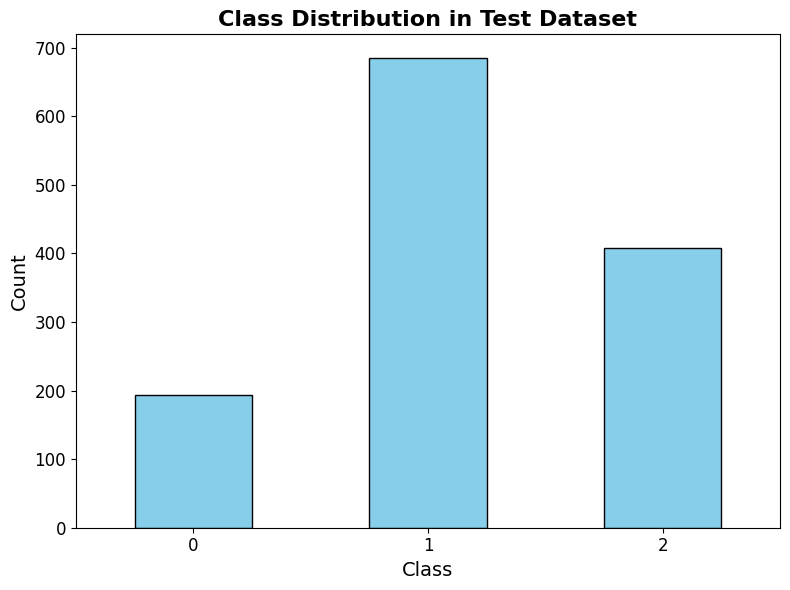


=== Generating Overall Metrics Plot ===


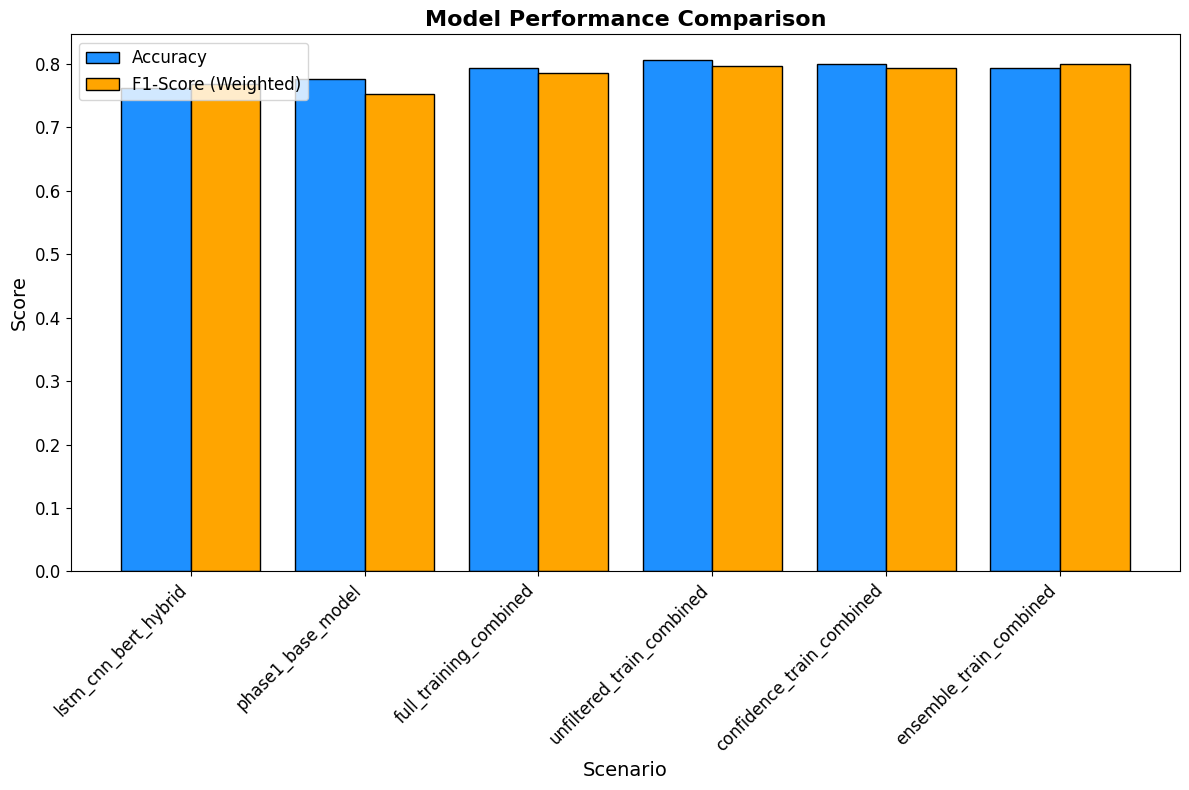


=== Collecting Confusion Matrices ===

=== Generating Confusion Matrix Grid ===


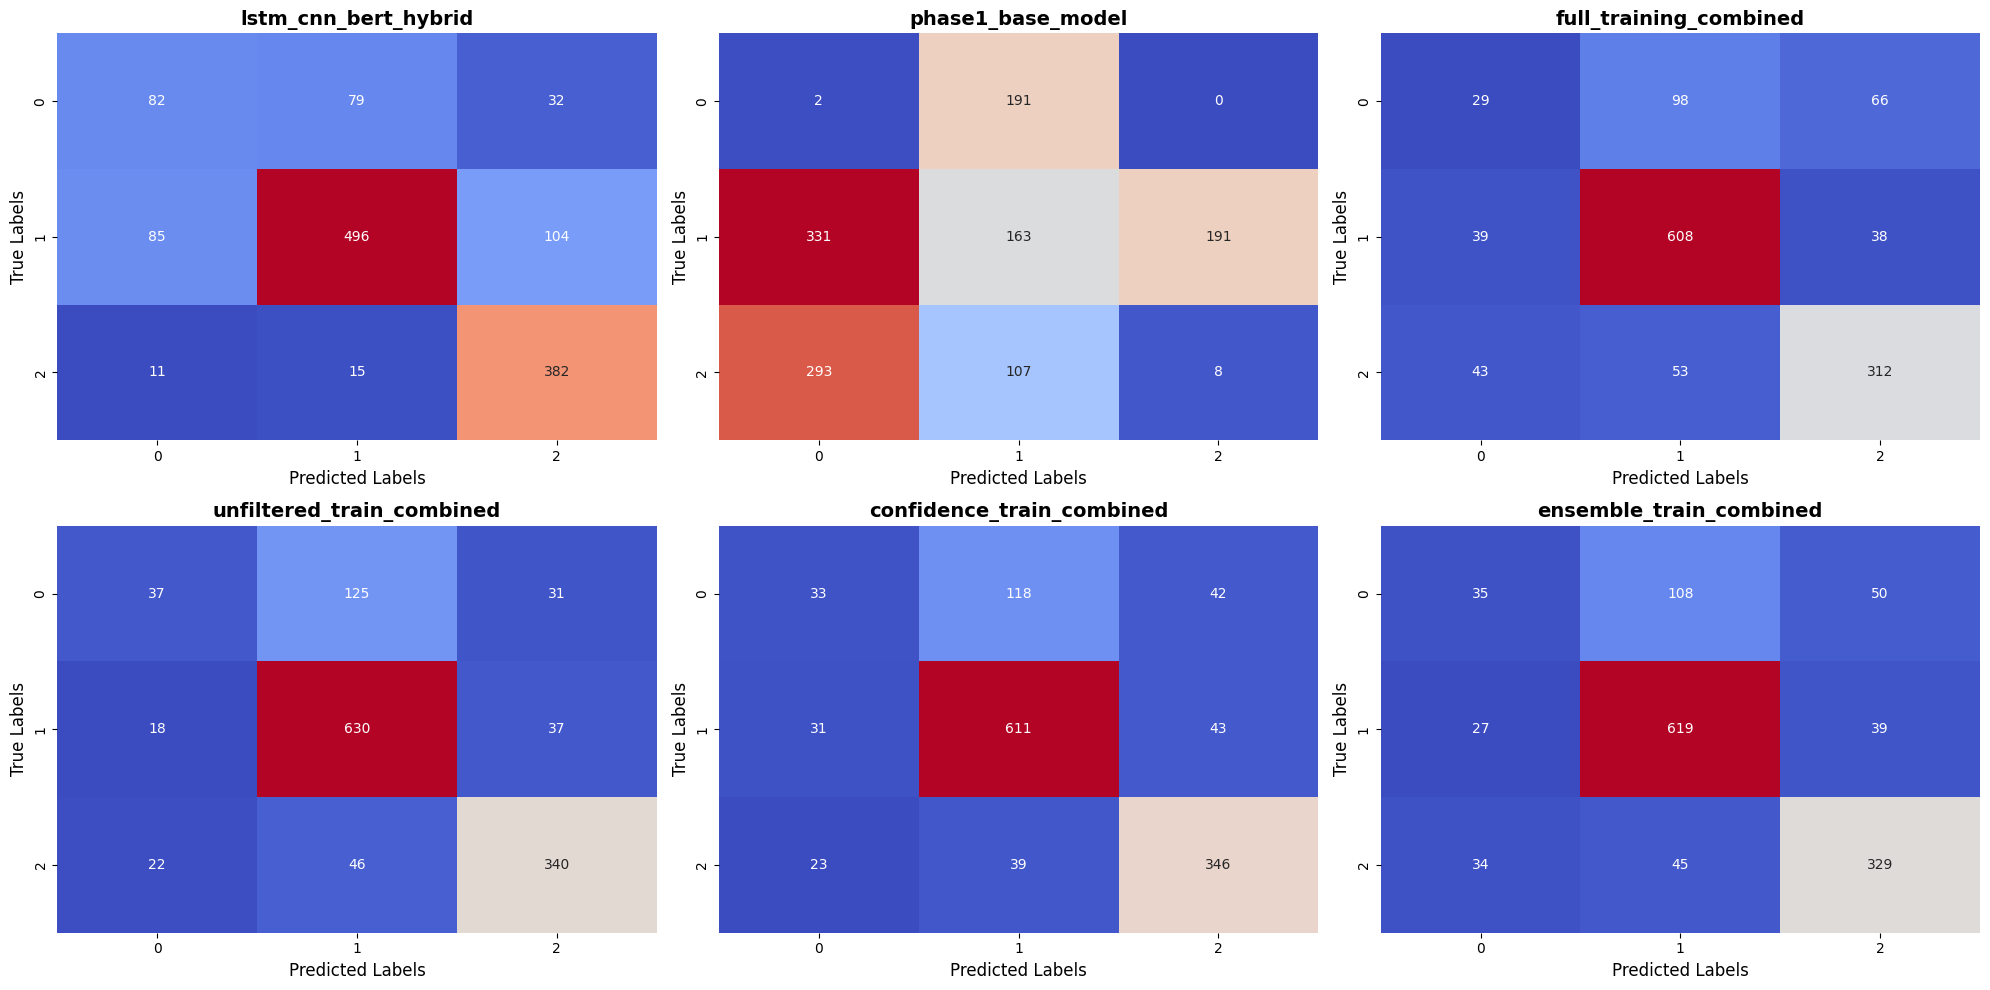


=== Generating Radar Plots for Class-Level Metrics ===


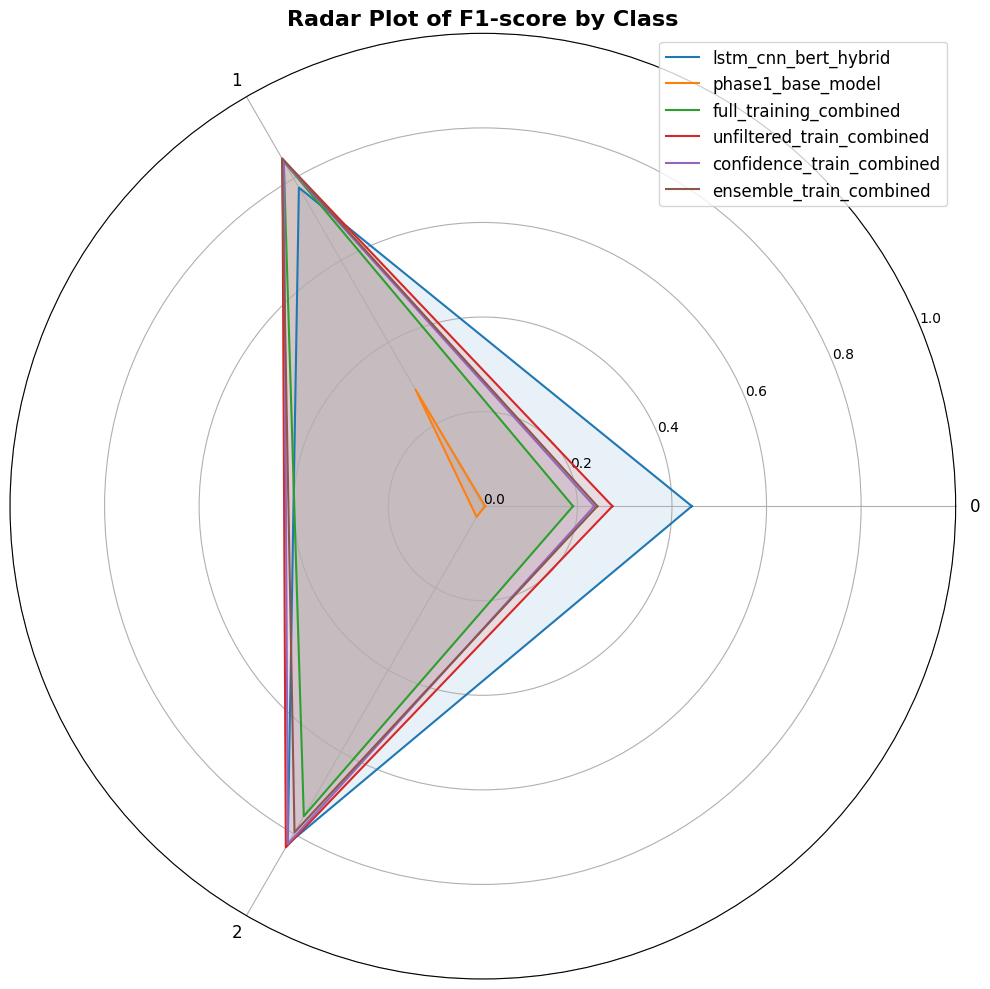

In [16]:
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from transformers import AutoTokenizer

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- Paths to Trained Models and Results ---
scenarios = {
    "lstm_cnn_bert_hybrid": "/content/drive/My Drive/models/hybrid_bert_lstm",
    "phase1_base_model": "/content/drive/My Drive/models/best_finbert_model",
    "full_training_combined": "/content/drive/My Drive/models/full_training_combined",
    "unfiltered_train_combined": "/content/drive/My Drive/models/unfiltered_train_combined",
    "confidence_train_combined": "/content/drive/My Drive/models/confidence_train_combined",
    "ensemble_train_combined": "/content/drive/My Drive/models/ensemble_train_combined",
}
results_path = "/content/drive/My Drive/models/comparison_results.csv"

# --- Load Saved Results ---
if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)
    print("Loaded previously saved results.")
else:
    print("Results file not found. Recompute results before visualization.")
    raise FileNotFoundError("Comparison results not available.")

# --- Load Test Dataset ---
splits_file_path = "/content/drive/My Drive/data_splits.json"
with open(splits_file_path, "r") as f:
    data_splits = json.load(f)
test_df = pd.DataFrame(data_splits["combined_test"])

# --- Class Distribution Analysis ---
def analyze_class_distribution(df, label_column, dataset_name):
    print(f"\n=== Class Distribution in {dataset_name} Dataset ===")
    class_counts = df[label_column].value_counts().sort_index()
    print(class_counts)
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(f"Class Distribution in {dataset_name} Dataset", fontsize=16, fontweight="bold")
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

analyze_class_distribution(test_df, "Sentiment", "Test")

# --- Visualize Overall Metrics (Accuracy and F1-Score) ---
def plot_overall_metrics(results_df):
    print("\n=== Generating Overall Metrics Plot ===")
    plt.figure(figsize=(12, 8))
    bar_width = 0.4
    index = np.arange(len(results_df))

    plt.bar(index - bar_width / 2, results_df["Accuracy"], bar_width, label="Accuracy", color="dodgerblue", edgecolor="black")
    plt.bar(index + bar_width / 2, results_df["F1-Score (Weighted)"], bar_width, label="F1-Score (Weighted)", color="orange", edgecolor="black")

    plt.title("Model Performance Comparison", fontsize=16, fontweight="bold")
    plt.xlabel("Scenario", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.xticks(index, results_df["Scenario"], rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc="upper left", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_overall_metrics(results_df)

# --- Confusion Matrix Visualization (Grid Layout) ---
def plot_confusion_matrix_grid(confusion_matrices, class_names):
    print("\n=== Generating Confusion Matrix Grid ===")
    num_models = len(confusion_matrices)
    ncols = 3
    nrows = (num_models + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 5))
    axes = axes.flatten()

    for idx, (scenario, cm) in enumerate(confusion_matrices.items()):
        sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_names, yticklabels=class_names, ax=axes[idx], cbar=False)
        axes[idx].set_title(f"{scenario}", fontsize=14, fontweight="bold")
        axes[idx].set_xlabel("Predicted Labels", fontsize=12)
        axes[idx].set_ylabel("True Labels", fontsize=12)
        axes[idx].tick_params(axis="both", labelsize=10)

    for idx in range(len(confusion_matrices), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

print("\n=== Collecting Confusion Matrices ===")
confusion_matrices = {}
for scenario, model_path in scenarios.items():
    cm_path = os.path.join(model_path, "confusion_matrix.json")
    if os.path.exists(cm_path):
        with open(cm_path, "r") as f:
            cm = json.load(f)
            cm = np.array(cm)
        confusion_matrices[scenario] = cm
    else:
        print(f"Confusion matrix for {scenario} not found. Skipping.")

if confusion_matrices:
    class_names = sorted(test_df["Sentiment"].unique())
    plot_confusion_matrix_grid(confusion_matrices, class_names)
else:
    print("No confusion matrices available for plotting.")

# --- Radar Plot for Class-Level Metrics ---
def radar_plot_class_metrics(class_reports, metric="f1-score"):
    print("\n=== Generating Radar Plots for Class-Level Metrics ===")
    classes = [str(cls) for cls in sorted(test_df["Sentiment"].unique())]
    angles = np.linspace(0, 2 * np.pi, len(classes), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    for scenario, report in class_reports.items():
        if isinstance(report, dict) and all(cls in report for cls in classes):
            metrics = [report[cls][metric] if metric in report[cls] else 0 for cls in classes]
            metrics += metrics[:1]
            ax.plot(angles, metrics, label=scenario)
            ax.fill(angles, metrics, alpha=0.1)

    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_title(f"Radar Plot of {metric.capitalize()} by Class", fontsize=16, fontweight="bold")
    ax.legend(loc="upper right", fontsize=12)
    plt.tight_layout()
    plt.show()

class_reports_path = "/content/drive/My Drive/models/class_reports.json"
if os.path.exists(class_reports_path):
    with open(class_reports_path, "r") as f:
        class_reports = json.load(f)
    radar_plot_class_metrics(class_reports, metric="f1-score")
else:
    print("Class reports not found. Skipping radar plot generation.")


In [13]:
import pandas as pd
import json
from sklearn.metrics import confusion_matrix

# --- Load Training Dataset ---
combined_train_path = "/content/drive/My Drive/data_splits.json"
with open(combined_train_path, "r") as f:
    data_splits = json.load(f)
combined_train = pd.DataFrame(data_splits["combined_train"])

# --- Check Class Distribution ---
def check_class_distribution(df, label_column, dataset_name):
    print(f"\n=== Class Distribution in {dataset_name} Dataset ===")
    class_counts = df[label_column].value_counts()
    print(class_counts)
    return class_counts

train_class_counts = check_class_distribution(combined_train, "Sentiment", "Training")

# --- Analyze Predictions ---
def analyze_predictions(predictions, true_labels, scenario):
    predicted_classes = set(predictions)
    true_classes = set(true_labels)
    print(f"\n=== Predicted vs True Classes for {scenario} ===")
    print(f"Predicted Classes: {predicted_classes}")
    print(f"True Classes: {true_classes}")
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

# Assuming `predictions` and `true_labels` are available
if 'predictions' in globals() and 'true_labels' in globals():
    analyze_predictions(predictions, true_labels, "Evaluation Scenarios")
else:
    print("\nError: `predictions` and/or `true_labels` not found in the current context.")



=== Class Distribution in Training Dataset ===
Sentiment
1    1759
2    1015
0     502
Name: count, dtype: int64

=== Predicted vs True Classes for Evaluation Scenarios ===
Predicted Classes: {0, 1, 2}
True Classes: {0, 1, 2}
Confusion Matrix:
[[ 35 108  50]
 [ 27 619  39]
 [ 34  45 329]]


Mounted at /content/drive
Loaded comparison results successfully:
                    Scenario  Accuracy  F1-Score (Weighted)
0       lstm_cnn_bert_hybrid  0.762053             0.768425
1          phase1_base_model  0.776050             0.753012
2     full_training_combined  0.793157             0.785834
3  unfiltered_train_combined  0.806376             0.796724
4  confidence_train_combined  0.800156             0.793505

Performance Summary Table:
                    Scenario  Accuracy  F1-Score (Weighted)
3  unfiltered_train_combined  0.806376             0.796724
4  confidence_train_combined  0.800156             0.793505
2     full_training_combined  0.793157             0.785834
5    ensemble_train_combined  0.793157             0.799418
1          phase1_base_model  0.776050             0.753012
0       lstm_cnn_bert_hybrid  0.762053             0.768425


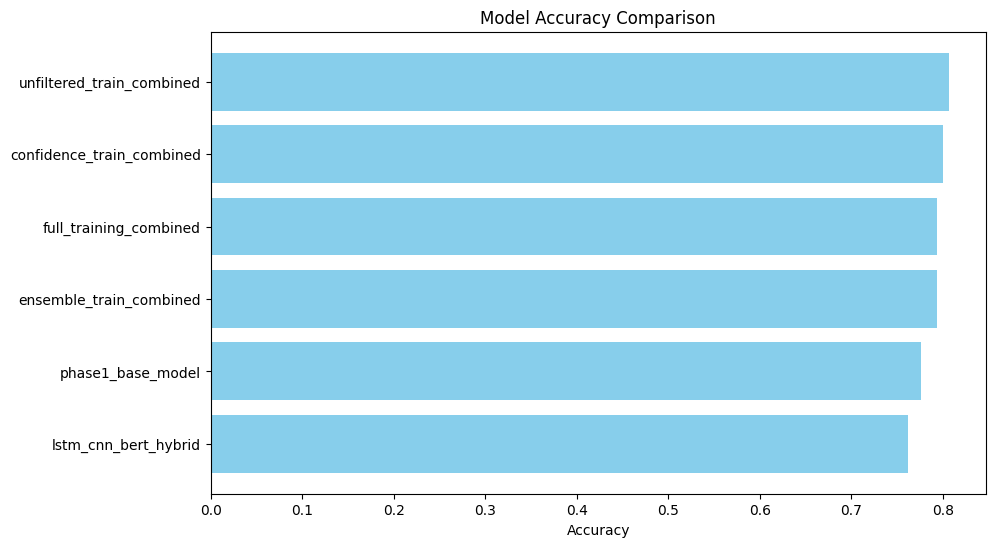

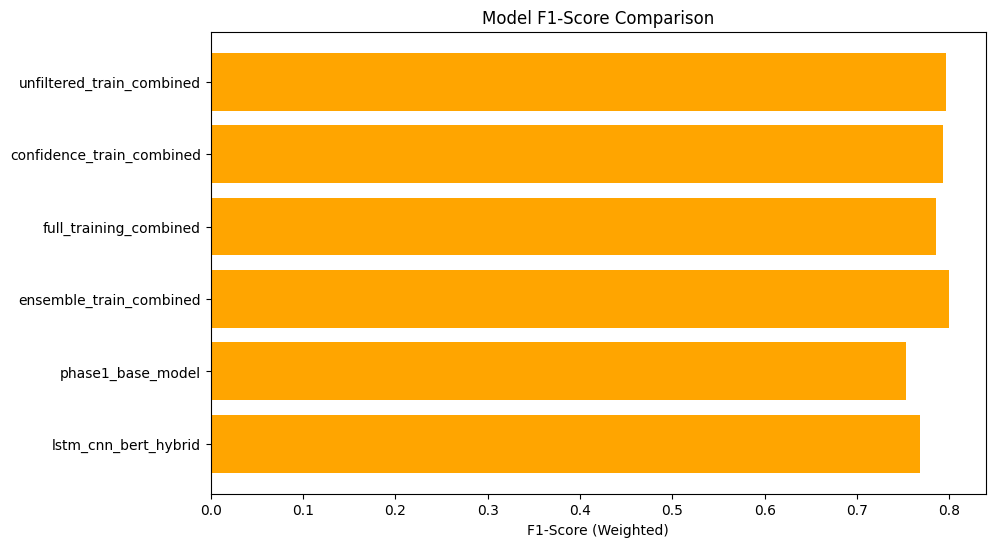

In [14]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# Path to the saved results file
results_path = "/content/drive/My Drive/models/comparison_results.csv"  # Ensure this matches your file path

# Load the saved results
try:
    results_df = pd.read_csv(results_path)
    print("Loaded comparison results successfully:")
    print(results_df.head())  # Display a preview of the results

    # Sort by Accuracy or F1-Score for clarity
    results_df = results_df.sort_values(by="Accuracy", ascending=False)

    # Display the sorted results
    print("\nPerformance Summary Table:")
    print(results_df)

    # Optionally save a cleaned-up version of the results
    results_df.to_csv("cleaned_model_performance_summary.csv", index=False)

    # Visualization: Accuracy
    plt.figure(figsize=(10, 6))
    plt.barh(results_df["Scenario"], results_df["Accuracy"], color="skyblue")
    plt.xlabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.gca().invert_yaxis()
    plt.show()

    # Visualization: F1-Score (Weighted)
    plt.figure(figsize=(10, 6))
    plt.barh(results_df["Scenario"], results_df["F1-Score (Weighted)"], color="orange")
    plt.xlabel("F1-Score (Weighted)")
    plt.title("Model F1-Score Comparison")
    plt.gca().invert_yaxis()
    plt.show()

except FileNotFoundError:
    print(f"Results file not found at {results_path}. Please ensure the results are saved before running this block.")
